In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
dataset_path = r"C:\Users\ADMIN\Desktop\archive" 

In [6]:
categories = os.listdir(dataset_path)
print("Categories:", categories)

Categories: ['TrashType_Image_Dataset']


In [8]:
import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras import layers, optimizers, callbacks  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D 
from tensorflow.keras import Layer 
from tensorflow.keras.applications import EfficientNetV2B2  

In [9]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr  

In [11]:
image_size = (124, 124)
batch_size = 32
seed = 42


In [14]:
dataset_path = r"C:\Users\ADMIN\Desktop\archive\TrashType_Image_Dataset"

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [20]:
print("✅ Dataset loaded.")
print("Class names:", train_ds.class_names)

✅ Dataset loaded.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


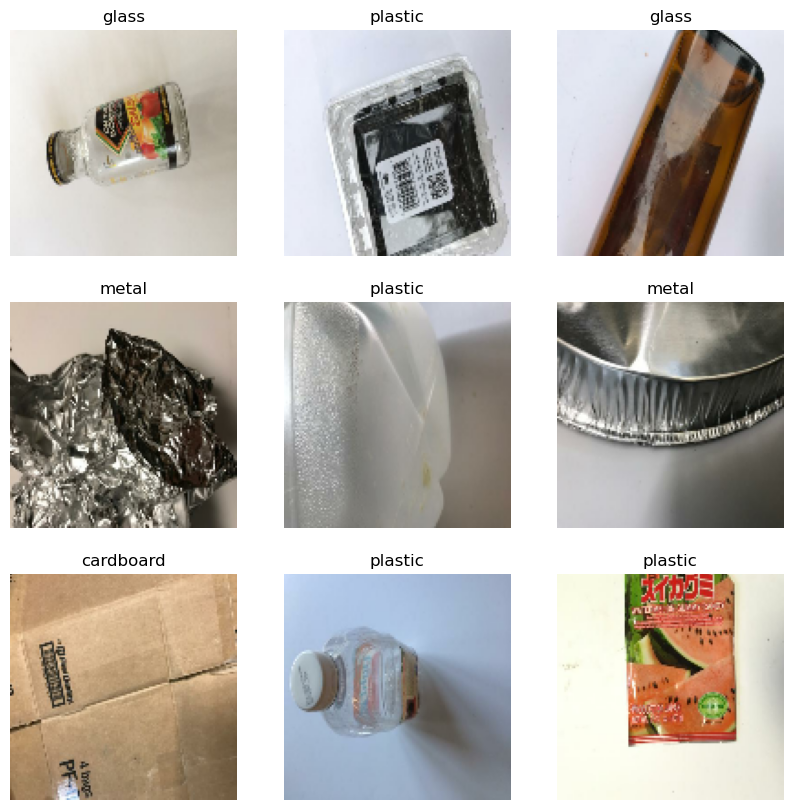

In [22]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [24]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [26]:
class_distribution = count_distribution(train_ds, class_names)
print("Training set class distribution (%):", class_distribution)


Training set class distribution (%): {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}


In [28]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


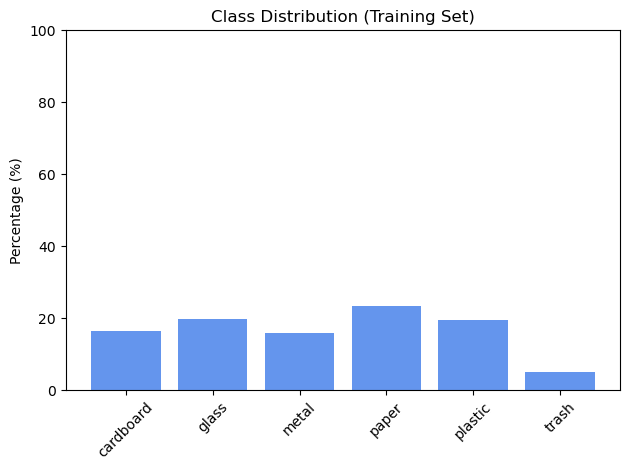

In [30]:
simple_bar_plot(class_distribution, "Class Distribution (Training Set)")

In [32]:
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
print("Total validation batches:", val_batches)


Total validation batches: 16


In [34]:
test_ds = val_ds.skip(val_batches // 2)
val_ds = val_ds.take(val_batches // 2)


In [36]:
test_dist = count_distribution(test_ds, class_names)
print("Test set class distribution (%):", test_dist)


Test set class distribution (%): {'cardboard': 12.45, 'glass': 23.69, 'metal': 16.06, 'paper': 23.29, 'plastic': 18.88, 'trash': 5.62}


In [38]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 12.85, 'glass': 22.09, 'metal': 16.06, 'paper': 26.51, 'plastic': 17.27, 'trash': 5.22}
{'cardboard': 15.29, 'glass': 18.66, 'metal': 16.36, 'paper': 24.14, 'plastic': 19.29, 'trash': 6.25}


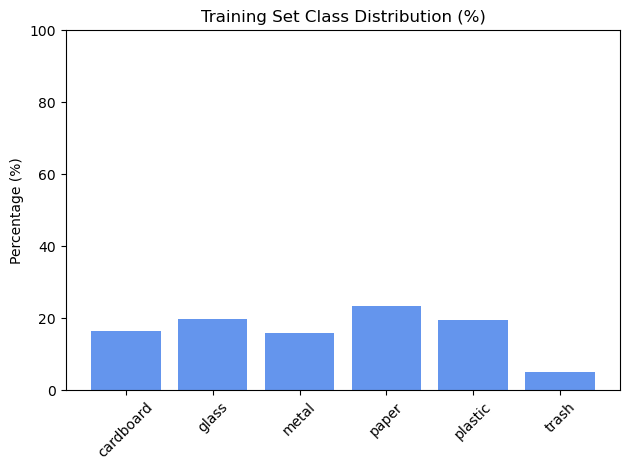

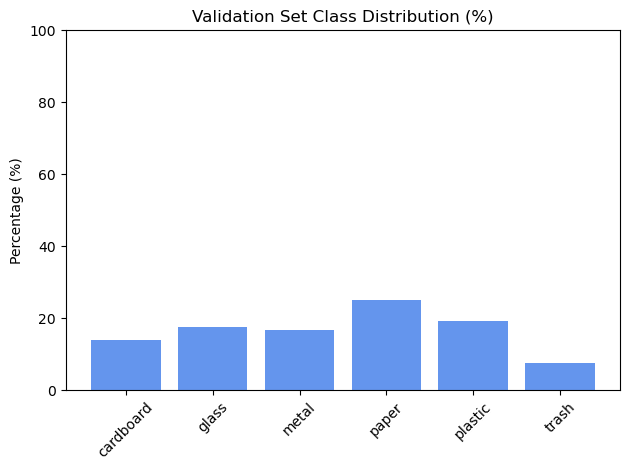

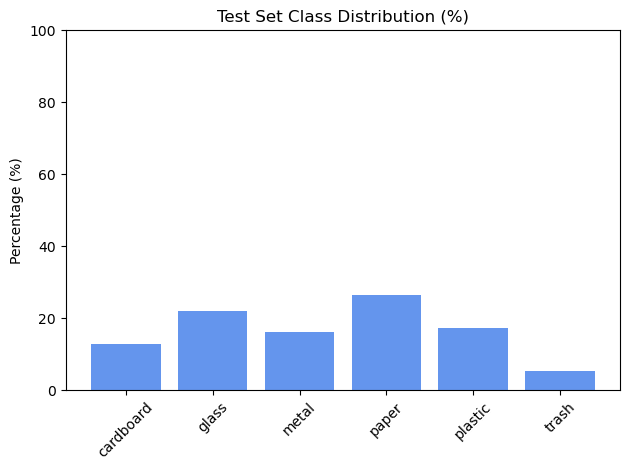

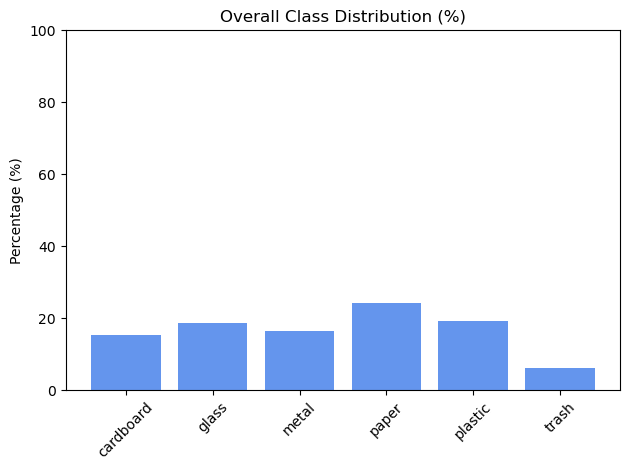

In [40]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    labels_np = labels.numpy()
    all_labels.extend(labels_np)
    for label in labels_np:
        class_counts[label] += 1

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

class_weights = {i: round(w, 2) for i, w in enumerate(class_weights_array)}


In [44]:
print("Class Counts (per index):", class_counts)
print("Class Weights (balanced):", class_weights)

Class Counts (per index): {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights (balanced): {0: 1.01, 1: 0.84, 2: 1.05, 3: 0.72, 4: 0.86, 5: 3.27}


In [46]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),   # was 0.1 — small change for more rotation variation
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [48]:
#  Load the pretrained EfficientNetV2B2 model without top layer
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),
                              include_preprocessing=True, weights='imagenet')

# Freeze first few layers to retain low-level pretrained features
base_model.trainable = True
for layer in base_model.layers[:120]:  # was 100 — slightly more frozen for stronger feature retention
    layer.trainable = False


In [50]:
# Build the final model architecture
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.25),  # was 0.3 — slight reduction for better balance
    layers.Dense(6, activation='softmax')  # 6 classes
])

In [52]:
# Compile the model with slight LR tweak
model.compile(
    optimizer=optimizers.Adam(learning_rate=1.5e-4),  # was 1e-4 — small increase
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [54]:
# EarlyStopping callback to prevent overfitting
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,                   # was 3 — slightly increased to allow 1 more epoch before stopping
    restore_best_weights=True
)

In [56]:
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3680 - loss: 1.5670 - val_accuracy: 0.6523 - val_loss: 0.9456
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7259 - loss: 0.8457 - val_accuracy: 0.8359 - val_loss: 0.5664
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8365 - loss: 0.5285 - val_accuracy: 0.8789 - val_loss: 0.3741
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8799 - loss: 0.3724 - val_accuracy: 0.8867 - val_loss: 0.3686
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9191 - loss: 0.2680 - val_accuracy: 0.8789 - val_loss: 0.3755
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9317 - loss: 0.2097 - val_accuracy: 0.8633 - val_loss: 0.3822
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9412 - loss: 0.1744 - val_accuracy: 0.8828 - val_loss: 0.3263
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.9585 - loss: 0.1432 - val_accuracy: 0.8984 - v

In [58]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,383,810 (93.02 MB)

 Trainable params: 7,802,990 (29.77 MB)

 Non-trainable params: 974,838 (3.72 MB)

 Optimizer params: 15,605,982 (59.53 MB)

In [60]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 124, 124, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 124, 124, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 31, 31, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,794,536 (29.73 MB)

 Non-trainable params: 974,838 (3.72 MB)

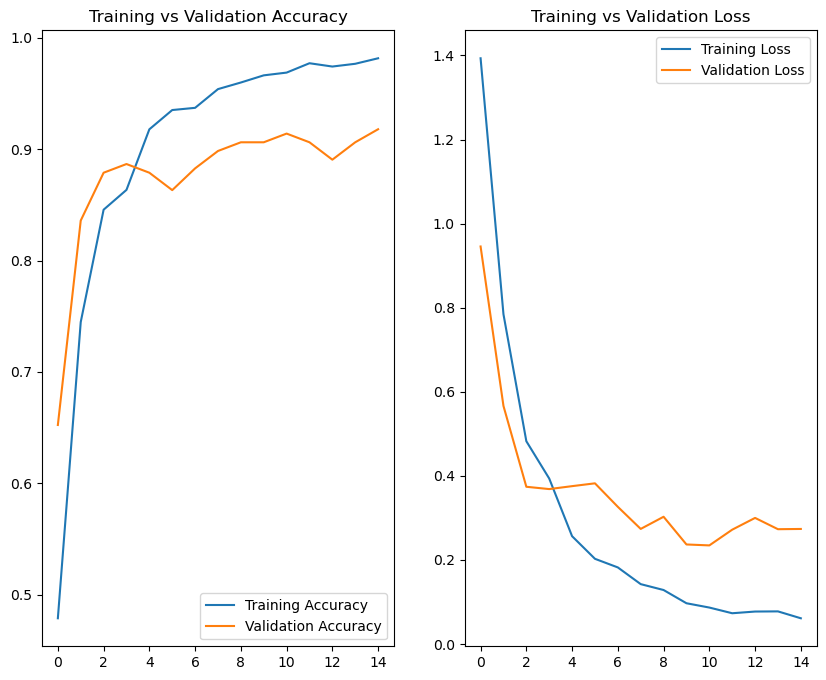

In [62]:
acc = history.history['accuracy']       
val_acc = history.history['val_accuracy']  
loss = history.history['loss']             
val_loss = history.history['val_loss']   

epochs_range = range(len(acc))             

plt.figure(figsize=(10,8))                 

plt.subplot(1,2,1)                         
plt.plot(epochs_range, acc, label='Training Accuracy')       
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')              
plt.title('Training vs Validation Accuracy') 

plt.subplot(1,2,2)                         
plt.plot(epochs_range, loss, label='Training Loss')         
plt.plot(epochs_range, val_loss, label='Validation Loss')   
plt.legend(loc='upper right')            
plt.title('Training vs Validation Loss')   

plt.show()    

In [64]:
# Evaluate model performance on test dataset
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"✅ Test Accuracy: {accuracy:.4f}")
print(f"✅ Test Loss: {loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 791ms/step - accuracy: 0.9125 - loss: 0.2644
✅ Test Accuracy: 0.8996
✅ Test Loss: 0.3179


In [66]:
 
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step 
[[ 6  6  8  5  5  2]
 [ 5  9 15  7  8  3]
 [ 4  9 10  8 10  5]
 [10 11  7 16 11  3]
 [ 8  7  9 18  6  1]
 [ 1  3  4  3  5  1]]
              precision    recall  f1-score   support

           0       0.18      0.19      0.18        32
           1       0.20      0.19      0.20        47
           2       0.19      0.22      0.20        46
           3       0.28      0.28      0.28        58
           4       0.13      0.12      0.13        49
           5       0.07      0.06      0.06        17

    accuracy                           0.19       249
   macro avg       0.17      0.18      0.17       249
weighted avg       0.19      0.19      0.19       249



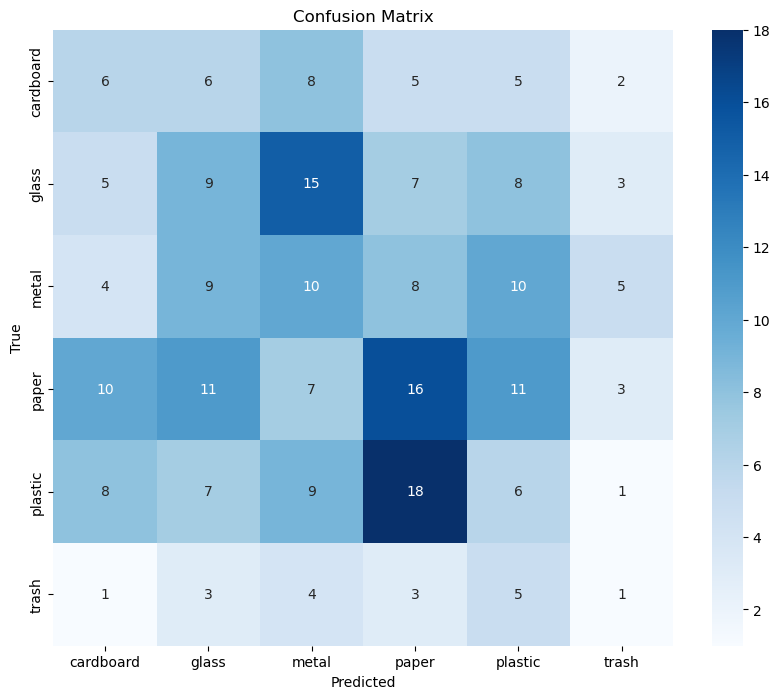

In [68]:
import seaborn as sns
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


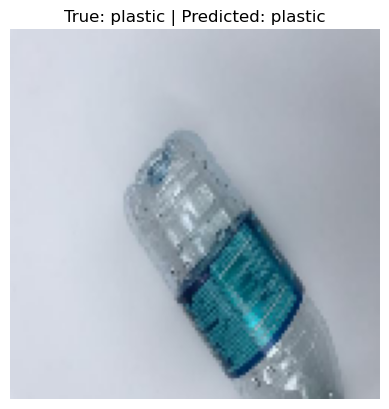

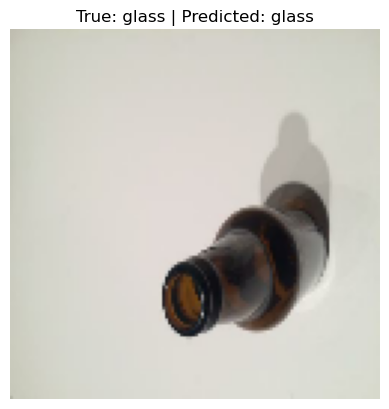

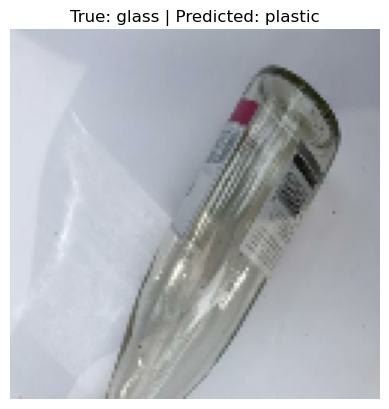

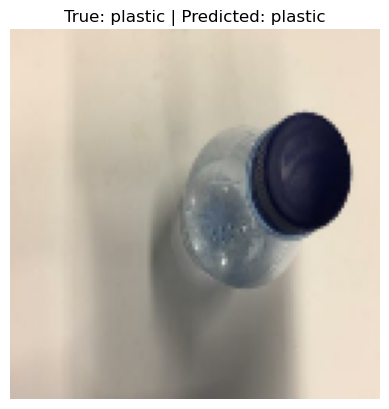

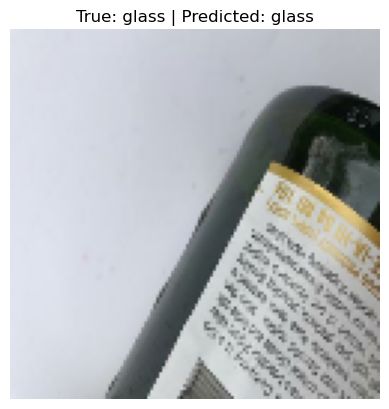

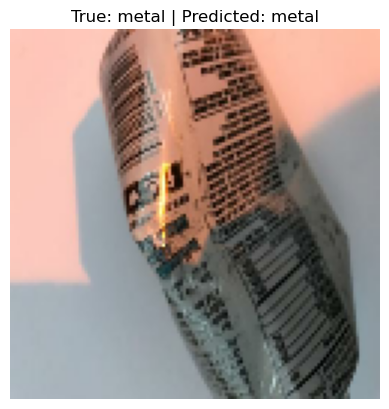

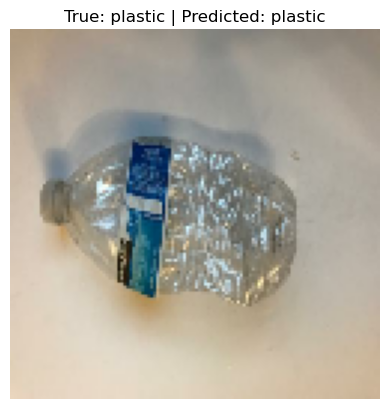

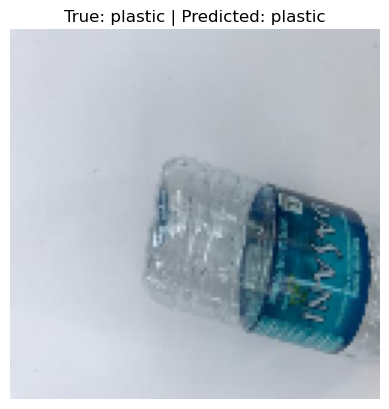

In [70]:
#  Display a few sample predictions from the test set
class_names = train_ds.class_names  

for images, labels in test_ds.take(1):  # `test_ds_eval` → `test_ds` for consistency
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):  # Show first 8 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]} | Predicted: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [72]:
# Save model in Keras format (includes weights, config, optimizer state)
model.save('EfficientNetV2B2_model.keras')  # fixed typo in filename

#  Optional: Load the saved model later
restored_model = tf.keras.models.load_model('EfficientNetV2B2_model.keras')


In [74]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [78]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [80]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
